## Import Required Libraries

In [1]:
# common libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import re
import helper 
import sklearn
import warnings
warnings.filterwarnings('ignore')

# machine learning libraries
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

## Load Data

In [2]:
# read csv file
data = pd.read_csv('../data/42_features.csv')


print('Shape of dataframe prior to modeling:', data.shape)
display(data)

Shape of dataframe prior to modeling: (1269, 42)


,test_oxycodone_0,test_cocaine_0,test_methamphetamine_0,test_opiate300_0,test_oxycodone_1,test_cocaine_1,test_methamphetamine_1,test_opiate300_1,test_oxycodone_2,test_cocaine_2,...,meds_methadone_2,meds_buprenorphine_2,meds_methadone_3,meds_buprenorphine_3,meds_methadone_4,meds_buprenorphine_4,cows_predose,cows_postdose,gender,dropout
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,46.0,0.0,27.0,0.0,55.0,11,6,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,7.0,0.0,9.0,0.0,7.0,8,1,0.0,0.0
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,44.0,0.0,60.0,0.0,51.0,0.0,8,5,1.0,0.0
3,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,27.0,0.0,23.0,0.0,9.0,11,9,0.0,0.0
4,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11,6,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1264,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11,8,0.0,1.0
1265,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,26,10,1.0,1.0
1266,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,14,6,0.0,1.0
1267,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,12,5,0.0,1.0


In [3]:
X, y = data.drop(columns=['dropout']), data['dropout']

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Shape of X_train:', X_train.shape)
print('Shape of X_test:', X_test.shape)

Shape of X_train: (1015, 41)
Shape of X_test: (254, 41)


In [4]:
X_train.iloc[10, :]

test_oxycodone_0             0.0
test_cocaine_0               1.0
test_methamphetamine_0       0.0
test_opiate300_0             1.0
test_oxycodone_1             0.0
test_cocaine_1               1.0
test_methamphetamine_1       0.0
test_opiate300_1             1.0
test_oxycodone_2             0.0
test_cocaine_2               1.0
test_methamphetamine_2       0.0
test_opiate300_2             1.0
test_oxycodone_3             0.0
test_cocaine_3               1.0
test_methamphetamine_3       0.0
test_opiate300_3             1.0
test_oxycodone_4             0.0
test_cocaine_4               1.0
test_methamphetamine_4       0.0
test_opiate300_4             1.0
survey_cocaine_0             1.0
survey_oxycodone_0           0.0
survey_methamphetamine_0     0.0
survey_opiates_0            30.0
survey_cocaine_4             5.0
survey_oxycodone_4           0.0
survey_methamphetamine_4     0.0
survey_opiates_4            34.0
meds_methadone_0             6.0
meds_buprenorphine_0         0.0
meds_metha

In [11]:
def perform_grid_search(X_train, y_train, X_val, y_val, classifier, hyperparams):
    """
    Perform grid search with cross-validation for a given classifier and hyperparameters.

    Parameters:
    - X_train: Training features dataframe.
    - y_train: Training target series.
    - X_val: Validation features dataframe.
    - y_val: Validation target series.
    - classifier: The classifier to use (e.g., XGBClassifier()).
    - hyperparams: Dictionary of hyperparameters to search.

    Returns:
    - results_df: Pandas DataFrame containing the results of the grid search.
    """
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import make_scorer
    # Define a custom scoring function for the C-index
    def cindex_score(y_true, y_pred):
        return helper.cindex(y_true, y_pred)

    # Wrap the custom scoring function using make_scorer
    cindex_scorer = make_scorer(cindex_score, greater_is_better=True)

    # Set up GridSearchCV with cross-validation and custom scorer
    grid_search = GridSearchCV(estimator=classifier, param_grid=hyperparams, cv=5, scoring=cindex_scorer, n_jobs=-1, verbose=1)

    # Fit GridSearchCV to the training data
    grid_search.fit(X_train, y_train)

    # Retrieve the best parameters
    best_params = grid_search.best_params_
    
    # Retrieve the best model
    best_model = grid_search.best_estimator_

    # calculate C-Index on the train set
    y_train_preds = best_model.predict_proba(X_train)[:, 1]
    c_index_train = helper.cindex(y_train.values, y_train_preds)

    # Calculate the C-index on the validation set
    y_val_preds = best_model.predict_proba(X_val)[:, 1]
    c_index = helper.cindex(y_val.values, y_val_preds)
    
    # Store the results in a DataFrame
    results = pd.DataFrame(grid_search.cv_results_)

    return results


In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# Assuming X_train and X_test are your feature matrices and y_train and y_test are your labels

# Identify categorical columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_cols)
    ],
    remainder='passthrough'  # Keep the rest of the columns unchanged
)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier())
])


# Fit the model
pipeline.fit(X_train, y_train)

# Get the probability scores
y_train_probs = pipeline.predict_proba(X_train)[:, 1]
y_test_probs = pipeline.predict_proba(X_test)[:, 1]

# Convert the probabilities to binary
y_train_preds = (y_train_probs > 0.5).astype(int)
y_test_preds = (y_test_probs > 0.5).astype(int)

# Calculate the c-index
print(f"Train C-Index: {helper.cindex(y_train.values, y_train_probs)}")
print(f"Test C-Index: {helper.cindex(y_test.values, y_test_probs)}")

# Plot the confusion matrix
helper.plot_confusion_matrix(y_test, y_test_preds, ['No Dropout', 'Dropout'], title='Confusion Matrix for XGBoost Model');

Fitting 5 folds for each of 4374 candidates, totalling 21870 fits


ValueError: Invalid parameter 'alpha' for estimator Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  Index([], dtype='object'))])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_me...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))]). Valid parameters are: ['memory', 'steps', 'verbose'].

In [ ]:

# Fit the model
pipeline.fit(X_train, y_train)

# Get the probability scores
y_train_probs = pipeline.predict_proba(X_train)[:, 1]
y_test_probs = pipeline.predict_proba(X_test)[:, 1]

# Convert the probabilities to binary
y_train_preds = (y_train_probs > 0.5).astype(int)
y_test_preds = (y_test_probs > 0.5).astype(int)

# Calculate the c-index
print(f"Train C-Index: {helper.cindex(y_train.values, y_train_probs)}")
print(f"Test C-Index: {helper.cindex(y_test.values, y_test_probs)}")

# Plot the confusion matrix
helper.plot_confusion_matrix(y_test, y_test_preds, ['No Dropout', 'Dropout'], title='Confusion Matrix for XGBoost Model');

In [6]:
# Extract the classifier from the pipeline
xgb = pipeline.named_steps['classifier']

# Print the classifier to verify
print(xgb)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)


In [7]:
import shap

# Assuming the previous code has been executed and the pipeline is already fitted

# Extract the fitted model from the pipeline
model = pipeline.named_steps['classifier']


# Create the SHAP explainer using the fitted model and the preprocessed training data
explainer = shap.Explainer(model, pipeline.named_steps['preprocessor'].transform(X_train))

# Calculate SHAP values for the training set
shap_values = explainer(pipeline.named_steps['preprocessor'].transform(X_train))

# Get the feature names from the preprocessor
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Remove prefixes from the feature names
clean_feature_names = [name.split('__')[-1] for name in feature_names]

# Create a SHAP values object with feature names
shap_values_with_names = shap.Explanation(values=shap_values.values, 
                                          base_values=shap_values.base_values, 
                                          data=shap_values.data, 
                                          feature_names=clean_feature_names)


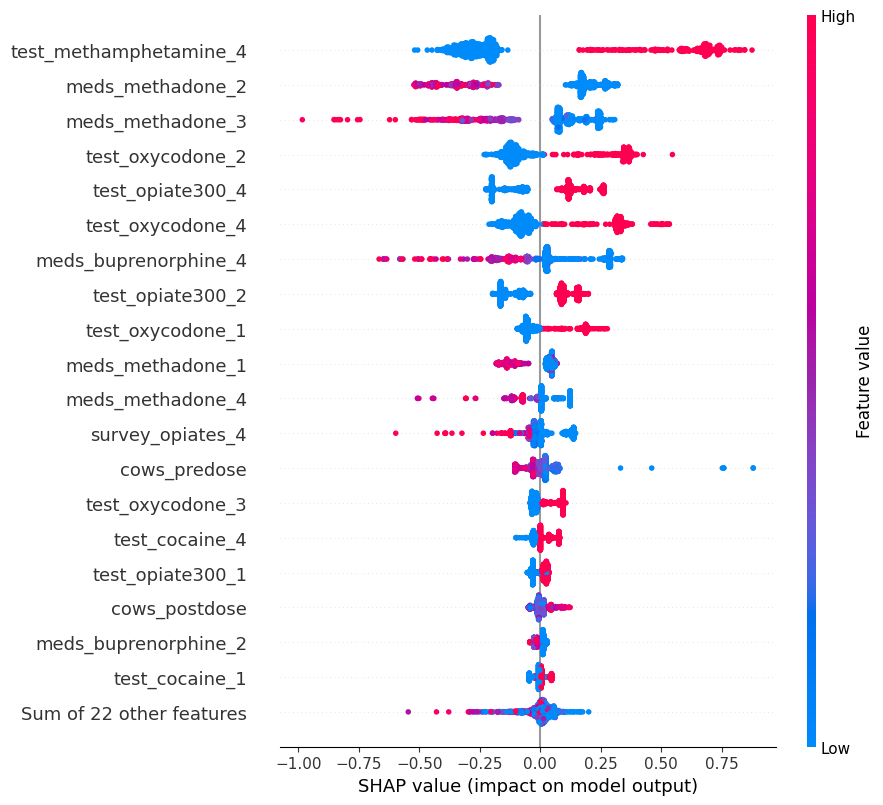

In [8]:

# Plot the SHAP beeswarm plot with feature names
shap.plots.beeswarm(shap_values_with_names, max_display=20, show=True)

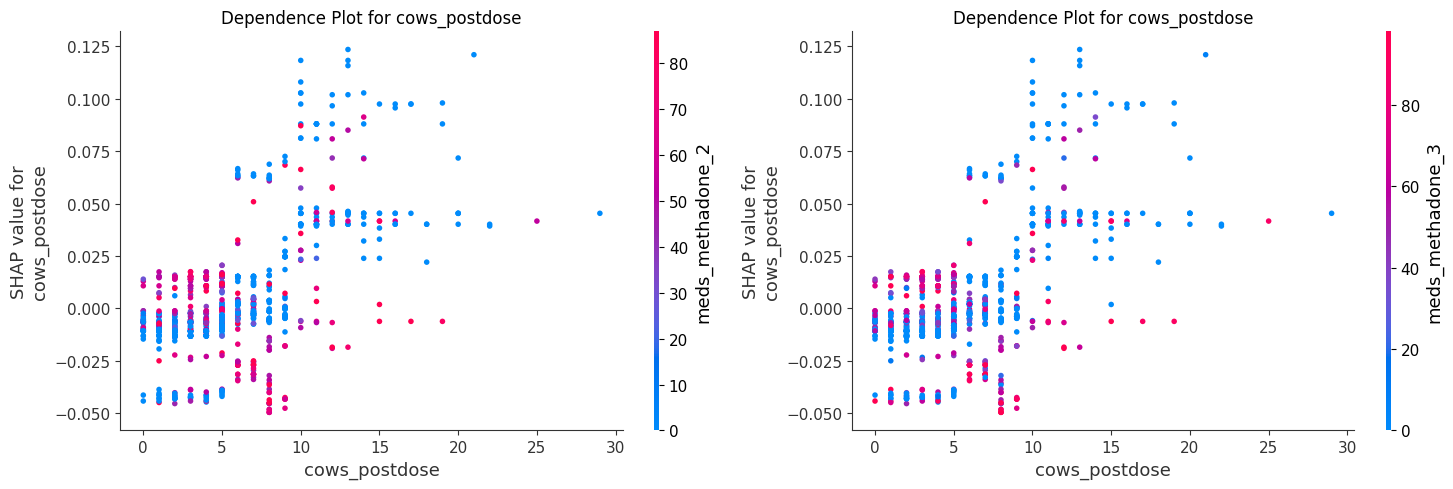

In [10]:
# create array object for dependence plot
shap_values_array = shap_values_with_names.values

# interaction 1
feature1 = 'cows_postdose'
feature2 = 'meds_methadone_2'

# interaction 2 
feature3 = 'cows_postdose'
feature4 = 'meds_methadone_3'

helper.plot_dependence(feature1, feature2, feature3, feature4, shap_values_array, X_train)

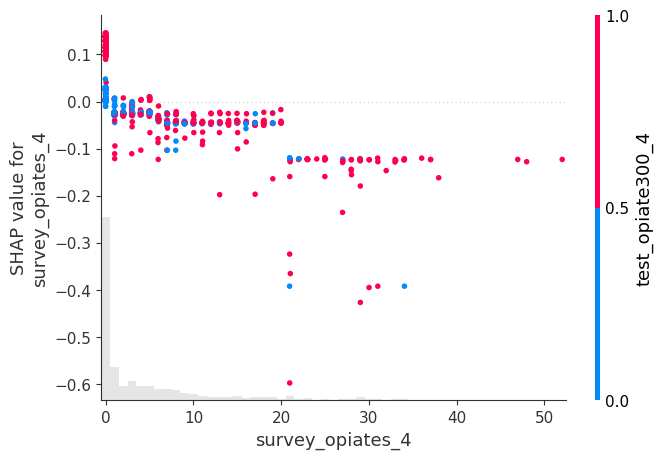

In [11]:
shap.plots.scatter(shap_values_with_names[:, 'survey_opiates_4'], color=shap_values_with_names[:, 'test_opiate300_4'], show=True)

## Look for Interactions - Self Reported Use with Opiate Tests

## Look for Interactions - Self Reported Use with Opiate Tests

In [ ]:
# clustering features
clustering = shap.utils.hclust(X_test, y_test)

shap.plots.bar(shap_values, clustering=clustering)

In [ ]:
# clustering features
clustering = shap.utils.hclust(X_test, y_test)

shap.plots.bar(shap_values, clustering=clustering, clustering_cutoff=1.5)

In [ ]:
# waterfall plot for clas index 0 
class_index = 1
data_index = np.random.choice(shap_values_with_names.shape[0])

print(f'Class index: {class_index}')
print(f'Data index: {data_index}')

shap.plots.waterfall(shap_values_with_names[0], max_display=10, show=True)

In [ ]:
shap.plots.waterfall(shap_values_with_names[0], max_display=10, show=True)

In [ ]:
data_index = np.random.choice(shap_values.shape[0])
class_index = 1
print(f'Class index: {class_index}')
print(f'Data index: {data_index}')
shap.plots.waterfall(shap_values_with_names[0], max_display=10, show=True)

In [ ]:
shap.initjs()

class_index = 1
data_index = np.random.choice(shap_values.shape[0])

print(f'Class index: {class_index}')
print(f'Data index: {data_index}')

shap.plots.force(shap_values_with_names[0], matplotlib=True)